<a href="https://colab.research.google.com/github/saisujith123/New1/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8-and-supervison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# YOLOv8 Tracking and Counting

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/OS5qI9YBkfk)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-tracking-and-counting/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks)

Ultralytics YOLOv8 is a popular version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## ⚠️ Disclaimer

This is an updated version of our [how-to-track-and-count-vehicles-with-yolov8](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8.ipynb) notebook, using the latest [supervision](https://github.com/roboflow/supervision) APIs.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the [blog post](https://blog.roboflow.com/yolov8-tracking-and-counting/) on how to train YOLOv8 Tracking and Counting, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv8
- Install Supervision
- Download example video
- Download video
- Load pre-trained YOLOv8 model
- Predict and annotate single frame
- Predict and annotate whole video

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Jun 26 07:10:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [3]:
!pip install ultralytics==8.3.19

# prevent ultralytics from tracking your activity
!yolo settings sync=False

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.19 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.5/112.6 GB disk)


## Install Roboflow Supervision

In [4]:
!pip install supervision[assets]==0.24.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.24.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download example video

In [6]:
from supervision.assets import download_assets, VideoAssets

SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_video.avi"

## Load pre-trained YOLOv8 model

In [7]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Maltech-tasks/Bags-Detection/best (1).pt")

In [8]:
model.model.names

{0: 'Lorry', 1: 'person_with_bag'}

## Predict and annotate single frame

In [9]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# the class names we have chosen
SELECTED_CLASS_NAMES = ['Lorry', 'person_with_bag']

# class ids matching the class names we have chosen
SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name
    in SELECTED_CLASS_NAMES
]

In [10]:
import supervision as sv
import numpy as np

Line cross

In [31]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO

# === Model and Video Paths ===
MODEL_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/best (1).pt"
VIDEO_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_video.avi"
OUTPUT_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_output.mp4"

# === Load YOLO Model ===
model = YOLO(MODEL_PATH)

# === Class ID mapping ===
CLASS_NAMES_DICT = {0: 'Lorry', 1: 'person_with_bag'}

# === Setup Annotators ===
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# === Initialize ByteTrack ===
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)

# === Video Setup ===
generator = sv.get_video_frames_generator(VIDEO_PATH)
first_frame = next(iter(sv.get_video_frames_generator(VIDEO_PATH)))
frame_height, frame_width = first_frame.shape[:2]

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, 30, (frame_width, frame_height))

# === Tracking Data ===
count = 0
crossed_ids = set()
prev_centers = {}

# === Frame Processing ===
for frame in sv.get_video_frames_generator(VIDEO_PATH):
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    # Filter detections
    lorry_detections = detections[detections.class_id == 0]
    person_detections = detections[detections.class_id == 1]

    annotated_frame = frame.copy()

    # === Detect lowest lorry and draw vertical line on left edge ===
    line_position_x = None
    line_start, line_end = (0, 0), (0, 0)
    has_lorry = False

    if len(lorry_detections) > 0:
        lorry_boxes = lorry_detections.xyxy
        lorry_boxes = sorted(lorry_boxes, key=lambda box: box[3], reverse=True)  # sort by bottom edge (y2)
        x1, y1, x2, y2 = lorry_boxes[0]

        line_position_x = int(x1) + 30  # Vertical line at left edge
        line_start = (line_position_x, int(y1) + 20)
        line_end = (line_position_x, int(y2) - 20)
        has_lorry = True

        # Draw the vertical yellow line
        cv2.line(annotated_frame, line_start, line_end, (0, 255, 255), 4)

    # === Count person_with_bag if crossing from left to right ===
    if has_lorry:
        for i, bbox in enumerate(person_detections.xyxy):
            x1, y1, x2, y2 = bbox
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)

            obj_id = person_detections.tracker_id[i]

            # Draw center point
            cv2.circle(annotated_frame, (center_x, center_y), 5, (255, 0, 0), -1)

            if obj_id in prev_centers:
                prev_x = prev_centers[obj_id]

                if prev_x < line_position_x and center_x >= line_position_x:
                    if obj_id not in crossed_ids:
                        count += 1
                        crossed_ids.add(obj_id)

            prev_centers[obj_id] = center_x

    # === Annotate Bounding Boxes and Labels ===
    labels = [CLASS_NAMES_DICT[class_id] for class_id in detections.class_id]
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # === Display Count ===
    cv2.putText(annotated_frame, f"Gunny Bags Count: {count}", (40, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

    # === Write Frame ===
    # === Write Frame ===
    bgr_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
    out.write(bgr_frame)
    cv2.imwrite("test_frame.jpg", bgr_frame)



# === Cleanup ===
out.release()
cv2.destroyAllWindows()
print(f"✅ Done! Output saved at: {OUTPUT_PATH}")


✅ Done! Output saved at: /content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_output.mp4


Loryy inside


In [32]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO

# === Paths ===
MODEL_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/best (1).pt"
VIDEO_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_video.avi"
OUTPUT_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_output.mp4"

# === Load Model ===
model = YOLO(MODEL_PATH)

# === Class Mapping ===
CLASS_NAMES_DICT = {0: 'Lorry', 1: 'person_with_bag'}

# === Annotators ===
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# === Initialize ByteTrack ===
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)

# === Video Setup ===
frame_gen = sv.get_video_frames_generator(VIDEO_PATH)
first_frame = next(iter(sv.get_video_frames_generator(VIDEO_PATH)))
height, width = first_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, 30, (width, height))

# === Track Info ===
count = 0
crossed_ids = set()
frame_index = 0

# === Process Each Frame ===
for frame in sv.get_video_frames_generator(VIDEO_PATH):
    if frame_index % 30 == 0:
        print(f"Processing frame: {frame_index}")

    # === Predict
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    # === Filter classes
    lorry_detections = detections[detections.class_id == 0]
    person_detections = detections[detections.class_id == 1]

    annotated_frame = frame.copy()

    # === Count if person_with_bag enters any lorry bounding box
    for i, bbox in enumerate(person_detections.xyxy):
        x1, y1, x2, y2 = bbox
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)

        obj_id = person_detections.tracker_id[i]
        if obj_id is None:
            continue

        # Draw center dot
        cv2.circle(annotated_frame, (center_x, center_y), 5, (255, 0, 0), -1)

        for lbox in lorry_detections.xyxy:
            lx1, ly1, lx2, ly2 = lbox
            if lx1 <= center_x <= lx2 and ly1 <= center_y <= ly2:
                if obj_id not in crossed_ids:
                    count += 1
                    crossed_ids.add(obj_id)
                break  # stop checking other lorries

    # === Draw bounding boxes and labels
    labels = [CLASS_NAMES_DICT[cid] for cid in detections.class_id]
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # === Show current count
    cv2.putText(annotated_frame, f"Gunny Bags Count: {count}", (40, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

    # === Convert to BGR and write
    bgr_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
    out.write(bgr_frame)

    frame_index += 1

# === Done
out.release()
cv2.destroyAllWindows()
print(f"✅ Done! Output saved to: {OUTPUT_PATH}")


Processing frame: 0
Processing frame: 30
Processing frame: 60
Processing frame: 90
Processing frame: 120
Processing frame: 150
Processing frame: 180
Processing frame: 210
Processing frame: 240
Processing frame: 270
Processing frame: 300
Processing frame: 330
Processing frame: 360
Processing frame: 390
Processing frame: 420
Processing frame: 450
Processing frame: 480
Processing frame: 510
Processing frame: 540
Processing frame: 570
Processing frame: 600
Processing frame: 630
Processing frame: 660
Processing frame: 690
Processing frame: 720
Processing frame: 750
Processing frame: 780
Processing frame: 810
Processing frame: 840
Processing frame: 870
Processing frame: 900
Processing frame: 930
Processing frame: 960
Processing frame: 990
Processing frame: 1020
Processing frame: 1050
Processing frame: 1080
Processing frame: 1110
Processing frame: 1140
Processing frame: 1170
Processing frame: 1200
Processing frame: 1230
Processing frame: 1260
Processing frame: 1290
Processing frame: 1320
Proc

Inside lorry + entry box crossing

In [33]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO

# === Paths ===
MODEL_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/best (1).pt"
VIDEO_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_video.avi"
OUTPUT_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_output.mp4"

# === Load YOLOv8 Model ===
model = YOLO(MODEL_PATH)

# === Class Mapping ===
CLASS_NAMES_DICT = {0: 'Lorry', 1: 'person_with_bag'}

# === Annotators ===
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# === Initialize ByteTrack ===
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)

# === Video Setup ===
frame_gen = sv.get_video_frames_generator(VIDEO_PATH)
first_frame = next(iter(sv.get_video_frames_generator(VIDEO_PATH)))
height, width = first_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, 30, (width, height))

# === Config ===
CONFIDENCE_THRESHOLD = 0.6
count = 0
crossed_ids = set()
prev_positions = {}  # tracker_id: (x, y)
frame_index = 0

# === Main Loop ===
for frame in sv.get_video_frames_generator(VIDEO_PATH):
    if frame_index % 30 == 0:
        print(f"Processing frame: {frame_index}")

    # Model Prediction
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    # Filter detections
    lorry_detections = detections[detections.class_id == 0]
    person_detections = detections[
        (detections.class_id == 1) & (detections.confidence > CONFIDENCE_THRESHOLD)
    ]

    annotated_frame = frame.copy()

    # For each person_with_bag
    for i, bbox in enumerate(person_detections.xyxy):
        x1, y1, x2, y2 = bbox
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)
        obj_id = person_detections.tracker_id[i]
        if obj_id is None:
            continue

        # Draw person center
        cv2.circle(annotated_frame, (center_x, center_y), 5, (255, 0, 0), -1)

        # Get previous position
        prev_center = prev_positions.get(obj_id, None)

        # Check if entering lorry
        for lbox in lorry_detections.xyxy:
            lx1, ly1, lx2, ly2 = lbox

            is_now_inside = (lx1 <= center_x <= lx2 and ly1 <= center_y <= ly2)
            was_outside = prev_center is not None and not (
                lx1 <= prev_center[0] <= lx2 and ly1 <= prev_center[1] <= ly2
            )

            if is_now_inside and was_outside:
                if obj_id not in crossed_ids:
                    count += 1
                    crossed_ids.add(obj_id)
                    print(f"Counted ID {obj_id} entering lorry.")

        # Update previous position
        prev_positions[obj_id] = (center_x, center_y)

    # === Annotate Bounding Boxes and Labels ===
    labels = [CLASS_NAMES_DICT[cid] for cid in detections.class_id]
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # === Show Count
    cv2.putText(annotated_frame, f"Gunny Bags Count: {count}", (40, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

    # === Write Frame
    bgr_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
    out.write(bgr_frame)

    frame_index += 1

# === Cleanup
out.release()
cv2.destroyAllWindows()
print(f"✅ Done! Final video saved to: {OUTPUT_PATH}")


Processing frame: 0
Processing frame: 30
Processing frame: 60
Processing frame: 90
Processing frame: 120
Processing frame: 150
Processing frame: 180
Processing frame: 210
Processing frame: 240
Processing frame: 270
Processing frame: 300
Processing frame: 330
Processing frame: 360
Counted ID 62 entering lorry.
Processing frame: 390
Processing frame: 420
Processing frame: 450
Processing frame: 480
Processing frame: 510
Processing frame: 540
Processing frame: 570
Processing frame: 600
Processing frame: 630
Processing frame: 660
Processing frame: 690
Processing frame: 720
Processing frame: 750
Processing frame: 780
Processing frame: 810
Processing frame: 840
Processing frame: 870
Counted ID 65 entering lorry.
Processing frame: 900
Processing frame: 930
Processing frame: 960
Processing frame: 990
Processing frame: 1020
Processing frame: 1050
Processing frame: 1080
Processing frame: 1110
Processing frame: 1140
Processing frame: 1170
Processing frame: 1200
Processing frame: 1230
Processing fr

INSIDE Lorry

In [35]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO

# === Paths ===
MODEL_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/best (1).pt"
VIDEO_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_video.avi"
OUTPUT_PATH = "/content/drive/MyDrive/Maltech-tasks/Bags-Detection/gunny_bags_output.mp4"

# === Load Model ===
model = YOLO(MODEL_PATH)

# === Class Mapping ===
CLASS_NAMES_DICT = {0: 'Lorry', 1: 'person_with_bag'}

# === Annotators ===
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# === Initialize ByteTrack ===
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3
)

# === Video Setup ===
frame_gen = sv.get_video_frames_generator(VIDEO_PATH)
first_frame = next(iter(sv.get_video_frames_generator(VIDEO_PATH)))
height, width = first_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, 30, (width, height))

# === Config ===
CONFIDENCE_THRESHOLD = 0.75
count = 0
crossed_ids = set()
frame_index = 0

# === Process Frames ===
for frame in sv.get_video_frames_generator(VIDEO_PATH):
    if frame_index % 30 == 0:
        print(f"Processing frame: {frame_index}")

    # Predict
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    # Filter classes
    lorry_detections = detections[detections.class_id == 0]
    person_detections = detections[
        (detections.class_id == 1) & (detections.confidence > CONFIDENCE_THRESHOLD)
    ]

    annotated_frame = frame.copy()

    # === Count if inside lorry (no entry logic)
    for i, bbox in enumerate(person_detections.xyxy):
        x1, y1, x2, y2 = bbox
        center_x = int((x1 + x2) / 2)
        center_y = int((y1 + y2) / 2)

        obj_id = person_detections.tracker_id[i]
        if obj_id is None:
            continue

        # Draw center point
        cv2.circle(annotated_frame, (center_x, center_y), 5, (255, 0, 0), -1)

        for lbox in lorry_detections.xyxy:
            lx1, ly1, lx2, ly2 = lbox
            if lx1 <= center_x <= lx2 and ly1 <= center_y <= ly2:
                if obj_id not in crossed_ids:
                    count += 1
                    crossed_ids.add(obj_id)
                    print(f"Counted ID {obj_id} inside lorry.")
                break  # Skip other lorries

    # === Annotate bounding boxes and labels
    labels = [CLASS_NAMES_DICT[cid] for cid in detections.class_id]
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # === Display count
    cv2.putText(annotated_frame, f"Gunny Bags Count: {count}", (40, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

    # === Write frame
    bgr_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
    out.write(bgr_frame)

    frame_index += 1

# === Finish
out.release()
cv2.destroyAllWindows()
print(f"✅ Done! Final video saved to: {OUTPUT_PATH}")


Processing frame: 0
Counted ID 81 inside lorry.
Processing frame: 30
Processing frame: 60
Processing frame: 90
Processing frame: 120
Processing frame: 150
Processing frame: 180
Processing frame: 210
Processing frame: 240
Processing frame: 270
Processing frame: 300
Processing frame: 330
Processing frame: 360
Counted ID 82 inside lorry.
Processing frame: 390
Processing frame: 420
Processing frame: 450
Processing frame: 480
Processing frame: 510
Processing frame: 540
Counted ID 83 inside lorry.
Processing frame: 570
Processing frame: 600
Counted ID 84 inside lorry.
Processing frame: 630
Processing frame: 660
Processing frame: 690
Processing frame: 720
Processing frame: 750
Processing frame: 780
Processing frame: 810
Processing frame: 840
Processing frame: 870
Counted ID 85 inside lorry.
Processing frame: 900
Processing frame: 930
Processing frame: 960
Processing frame: 990
Counted ID 86 inside lorry.
Processing frame: 1020
Processing frame: 1050
Processing frame: 1080
Processing frame: 11

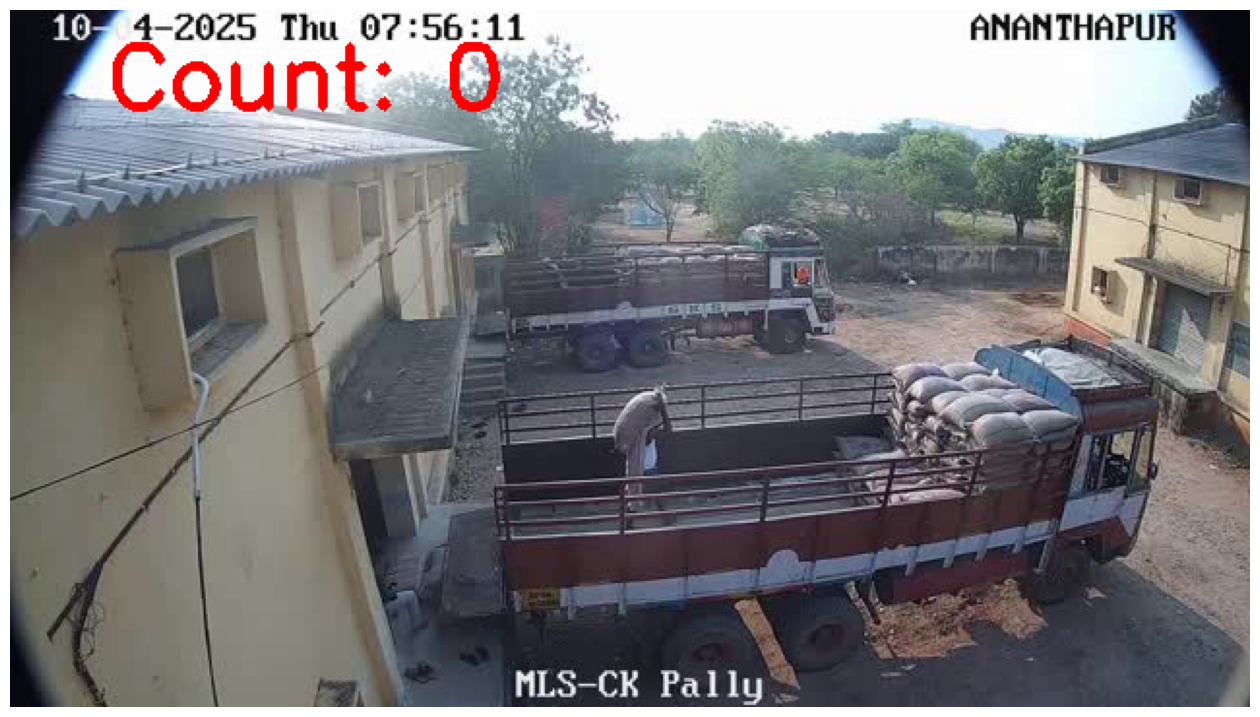

In [16]:
import numpy as np
import cv2

# Define counting line (example: horizontal line from x=100 to x=1000 at y=400)
line_start = (100, 400)
line_end = (1000, 400)
line_position_y = 400  # y-coordinate for crossing check
crossed_ids = set()  # to store object IDs that already crossed
count = 0  # gunny bag count

# Create video frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Box and label annotators
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)

# Initialize ByteTrack
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3)


# Iterate over frames
for frame in generator:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    # Optional: assign unique IDs (tracking)
    detections = byte_tracker.update_with_detections(detections)

    # Draw counting line
    annotated_frame = frame.copy()
    cv2.line(annotated_frame, line_start, line_end, (0, 255, 255), 4)

    labels = [
        f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
        for confidence, class_id in zip(detections.confidence, detections.class_id)
    ]

    # Draw boxes and labels
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Count if crossed line (based on object center y crossing the line)
    for i, bbox in enumerate(detections.xyxy):
        x1, y1, x2, y2 = bbox
        center_y = int((y1 + y2) / 2)
        obj_id = detections.tracker_id[i]

        if obj_id is not None and obj_id not in crossed_ids:
            if center_y > line_position_y - 5 and center_y < line_position_y + 5:
                count += 1
                crossed_ids.add(obj_id)

    # Show current count on frame
    cv2.putText(annotated_frame, f"Count: {count}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)

    # Display the frame (optional for debugging)
    sv.plot_image(annotated_frame, (16, 16))
    break  # Remove this `break` for full video loop

## Predict and annotate whole video

In [ ]:
# settings
LINE_START = sv.Point(0 + 50, 1500)
LINE_END = sv.Point(3840 - 50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

In [ ]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3)

byte_tracker.reset()

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator, LabelAnnotator, and TraceAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.